# Awareness Modeling


In [1]:
%matplotlib inline
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from scipy import sparse, stats, spatial
from sklearn.preprocessing import StandardScaler
from pygsp import graphs, filters, plotting
from sklearn.decomposition import NMF, LatentDirichletAllocation


## Import the features from different pickles : 

In [2]:
# Helper function to standardize values in a list
def stand(mylist):  
    std_scaler = StandardScaler().fit(np.array(mylist).reshape(-1, 1))
    return std_scaler.transform(np.array(mylist).reshape(-1, 1)) 

# Helper function to standardize values in a dataframe
def stand_df(df):
    maxvalue = df.replace(np.inf,0.0).max().max()
    infvalreplace = 2 * maxvalue
    df.replace(np.inf,infvalreplace,inplace=True)
    df.replace(np.nan,infvalreplace,inplace=True)
    myindex = df.index
    mycolumns = df.columns
    mylist = df.as_matrix()
    myshape = np.shape(mylist)
    std_scaler = StandardScaler().fit(np.array(mylist).reshape(-1, 1))
    scaled_list = std_scaler.transform(np.array(mylist).reshape(-1, 1)).reshape(myshape)   
    return pd.DataFrame(scaled_list,index=myindex,columns=mycolumns)

In [3]:
# Loading the dataframe containing general information about countries
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))
countries = c_data.index.tolist()
c_data = c_data.reset_index()
c_data = c_data.set_index("ISO2")

# Keep only relevant fields 
c_data = c_data[['ISO2','POP', 'area', 'gdp', 'gdp_capita', 'pop_pov']]
# Removing multi indexing 
c_data.columns = c_data.columns.droplevel(level = 1)


# Load all the distance metrics created between the different countries
lang_feature_df = pd.read_pickle('../LinkingLanguages/country_dist_languages.pkl')
lang_feature_df = stand_df(lang_feature_df)
lang_feature_df -= lang_feature_df.min().min()

fligh_routes_df = pd.read_pickle('../GeoMetrics/flight_routes_std.pickle')
hop_distance_df = pd.read_pickle('../GeoMetrics/hop_distance_std.pickle')
neighbor_influence_df = pd.read_pickle('../GeoMetrics/neighbor_influence.pickle')
dist_feature_df = pd.read_pickle('../GeoMetrics/real_distance_std.pickle')
religion_and_more_df = pd.read_pickle('../GeoMetrics/rel_distance_df.pickle')
religion_and_more_df = stand_df(religion_and_more_df)
religion_and_more_df = religion_and_more_df - religion_and_more_df.min().min()

# Shift the standardized values by the minimum for the NMF :
lang_feature_df = lang_feature_df - lang_feature_df.min().min()
fligh_routes_df = fligh_routes_df - fligh_routes_df.min().min()
hop_distance_df = hop_distance_df - hop_distance_df.min().min()
neighbor_influence_df = neighbor_influence_df - neighbor_influence_df.min().min()
dist_feature_df = dist_feature_df - dist_feature_df.min().min()
#religion_and_more_df = religion_and_more_df - religion_and_more_df.min().min()


# Concatenate the dataframes with multi indexing
features_df = pd.concat([fligh_routes_df,
                         hop_distance_df,
                         neighbor_influence_df,
                         dist_feature_df],axis=1)

features_df.sort_index(axis=1,inplace=True)

# Removing multi indexing 
features_df.columns = features_df.columns.droplevel(level = 0)

# Concatenating remaining dataframes
features_df = pd.concat([features_df, lang_feature_df, religion_and_more_df,c_data], axis=1)

features_df.head(10)


,AD,AE,AF,AG,AI,AL,AM,AO,AQ,AR,...,WS,YE,ZA,ZM,ZW,POP,area,gdp,gdp_capita,pop_pov
AD,inf,inf,inf,0.119521,0.243244,inf,inf,inf,inf,inf,...,0.915975,1.716053,0.454804,2.616480,2.609464,85660.0,468.0,4.800000e+09,37200.0,0.143
AE,inf,inf,0.0966982,inf,inf,inf,0.0246263,0.0246263,inf,inf,...,1.230872,1.255804,0.972257,2.741310,2.734322,5927482.0,83600.0,3.750000e+11,67700.0,0.195
AF,inf,2.5044,inf,inf,inf,inf,inf,inf,inf,inf,...,2.873806,1.218927,2.753572,1.542684,1.530756,33332025.0,652230.0,1.840000e+10,2000.0,0.358
AG,0.292734,inf,inf,inf,0.292734,inf,inf,inf,inf,inf,...,0.146233,1.909949,0.387058,2.443685,2.439571,93581.0,442.0,1.303000e+09,24100.0,NaN
AI,4.15291,inf,inf,2.07435,inf,inf,inf,inf,inf,inf,...,0.153756,1.935923,0.446509,2.443410,2.438111,16752.0,91.0,1.754000e+08,12200.0,0.230
AL,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,1.131696,1.332125,0.812311,2.699132,2.698836,3038594.0,28748.0,1.214000e+10,11900.0,0.143
AM,inf,0.447657,inf,inf,inf,inf,inf,inf,inf,inf,...,2.462592,2.060699,2.536426,0.332234,0.238809,3051250.0,29743.0,1.075000e+10,8900.0,0.320
AO,inf,0.71254,inf,inf,inf,inf,inf,inf,inf,inf,...,2.487915,1.847019,2.472921,0.520096,0.609225,20172332.0,1246700.0,9.194000e+10,6800.0,0.405
AQ,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,1.524710,1.207935,1.300991,1.545567,1.533660,NaN,14000000.0,NaN,NaN,NaN
AR,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,2.732608,2.050256,2.681908,1.250916,1.360277,43886748.0,2780400.0,5.417000e+11,20200.0,0.300


In [4]:
#print([x for x in features_df.columns])

In [5]:
# convert every Nan to a 0 
features_df.fillna(value=0,inplace=True)
# replace inf by a large number :
features_df.replace(np.inf, 1E5,inplace=True)

to_standadize = ['POP','area','gdp', 'gdp_capita','pop_pov']
for i in to_standadize:
    
    features_df.loc[:,i] = stand(list(features_df.loc[:,i])).reshape((-1))
    features_df.loc[:,i] -=  features_df.loc[:,i].min()

features_df.head(20)

,AD,AE,AF,AG,AI,AL,AM,AO,AQ,AR,...,WS,YE,ZA,ZM,ZW,POP,area,gdp,gdp_capita,pop_pov
AD,100000.000000,100000.000000,100000.000000,0.119521,0.243244,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,0.915975,1.716053,0.454804,2.616480,2.609464,0.000694,0.000245,0.003290,1.664981,0.723367
AE,100000.000000,100000.000000,0.096698,100000.000000,100000.000000,100000.000000,0.024626,0.024626,100000.0,100000.0,...,1.230872,1.255804,0.972257,2.741310,2.734322,0.048028,0.043702,0.257045,3.030086,0.986409
AF,100000.000000,2.504397,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,2.873806,1.218927,2.753572,1.542684,1.530756,0.270073,0.340954,0.012612,0.089515,1.810946
AG,0.292734,100000.000000,100000.000000,100000.000000,0.292734,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,0.146233,1.909949,0.387058,2.443685,2.439571,0.000758,0.000232,0.000893,1.078657,0.000000
AI,4.152905,100000.000000,100000.000000,2.074351,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,0.153756,1.935923,0.446509,2.443410,2.438111,0.000136,0.000048,0.000120,0.546042,1.163457
AL,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,1.131696,1.332125,0.812311,2.699132,2.698836,0.024620,0.015029,0.008321,0.532615,0.723367
AM,100000.000000,0.447657,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,2.462592,2.060699,2.536426,0.332234,0.238809,0.024723,0.015549,0.007369,0.398342,1.618723
AO,100000.000000,0.712540,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,2.487915,1.847019,2.472921,0.520096,0.609225,0.163447,0.651713,0.063021,0.304351,2.048696
AQ,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,1.524710,1.207935,1.300991,1.545567,1.533660,0.000000,7.318500,0.000000,0.000000,0.000000
AR,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.0,...,2.732608,2.050256,2.681908,1.250916,1.360277,0.355593,1.453455,0.371310,0.904102,1.517553


## Applying the NMF

In [6]:
features_mat = features_df.as_matrix()


In [7]:
n_samples = np.shape(features_mat)[1]
n_features = len(features_df.columns)
n_components = round(np.shape(features_mat)[1]/3)

In [8]:
W = LatentDirichletAllocation(n_components=n_components, max_iter=20,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0).fit_transform(features_mat)

In [9]:
np.shape(W)

(248, 496)

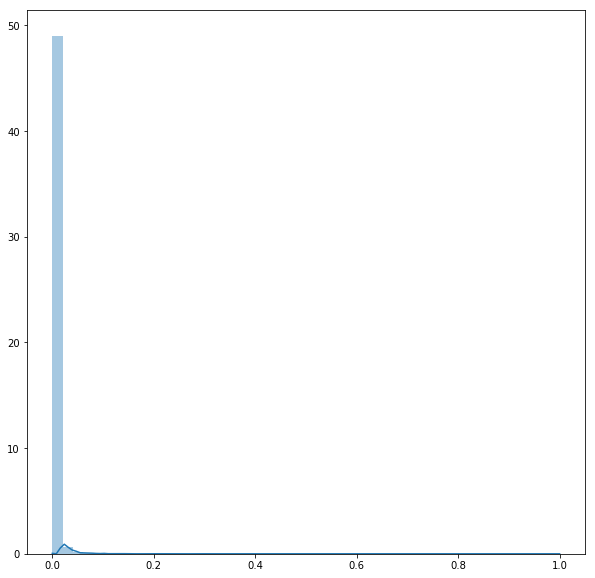

In [10]:
plt.figure(figsize=[10,10])
sns.distplot(W.flatten())

## Weight Matrix and Graph

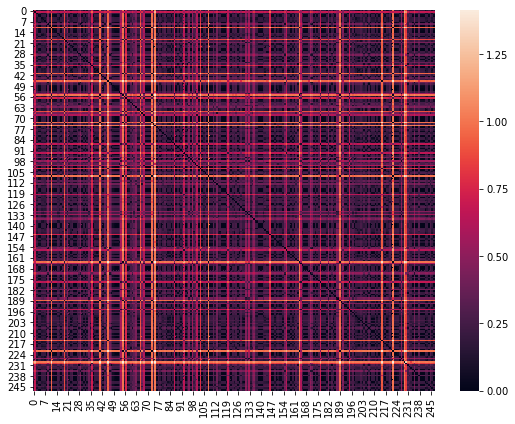

In [11]:
distances = spatial.distance.squareform(spatial.distance.pdist(W)) # W
plt.figure(figsize=[9,7])
sns.heatmap(distances)

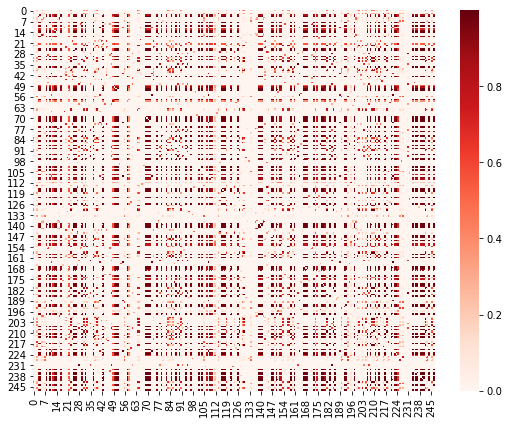

In [12]:
kernel_width = np.mean(distances)- np.std(distances)#distances.mean()

def kernel(x):
    return np.exp(- np.power(x/kernel_width,2))

# applying the kernel to the distances matrix :
weights = kernel(distances)
# setting the diagonal (self-loops) weights to 0 :
weights[range(len(weights)),range(len(weights))] = 0

# displaying a subset of the weights matrix :
plt.figure(figsize=[9,7])
sns.heatmap(weights,cmap="Reds")

In [13]:
weights_df = pd.DataFrame(weights,columns=countries,index=countries)

In [14]:
country = 'Germany'
weights_df[country].loc[weights_df[country] >= 0.9].sort_values(ascending=False)


Åland Islands                       0.994303
Saint Vincent and the Grenadines    0.992073
Cambodia                            0.991629
Uzbekistan                          0.988820
Barbados                            0.985303
Gibraltar                           0.985273
Bosnia and Herzegovina              0.985116
Australia                           0.985116
Kenya                               0.984937
Papua New Guinea                    0.984934
Qatar                               0.984905
Norway                              0.984787
Tunisia                             0.984760
Costa Rica                          0.984653
Greece                              0.984566
Suriname                            0.984511
Isle of Man                         0.984314
Sierra Leone                        0.984283
Argentina                           0.984238
Ethiopia                            0.984202
Finland                             0.984133
Venezuela                           0.984118
Central Af

In [15]:
weights_df.head()

,Aruba,Afghanistan,Angola,Anguilla,Åland Islands,Albania,Andorra,United Arab Emirates,Argentina,Armenia,...,British Virgin Islands,United States Virgin Islands,Vietnam,Vanuatu,Wallis and Futuna,Samoa,Yemen,South Africa,Zambia,Zimbabwe
Aruba,0.000000e+00,2.534647e-34,2.335948e-01,7.584046e-04,9.857710e-04,2.251268e-01,7.597078e-02,5.778240e-02,1.022255e-03,8.765855e-13,...,1.760289e-06,9.620998e-04,9.974588e-04,9.764878e-04,4.969534e-01,3.442602e-02,9.971338e-04,9.132733e-06,3.389176e-01,9.753205e-04
Afghanistan,2.534647e-34,0.000000e+00,1.522437e-32,3.936823e-34,5.054514e-34,6.132989e-33,1.873776e-30,3.241776e-31,5.240801e-34,4.559919e-43,...,2.361334e-25,4.953838e-34,5.117288e-34,5.038631e-34,6.018185e-35,8.857248e-33,5.118184e-34,1.211886e-31,6.555160e-34,5.012380e-34
Angola,2.335948e-01,1.522437e-32,0.000000e+00,1.744746e-03,2.265920e-03,2.099053e-01,9.392667e-02,1.539295e-01,2.351345e-03,2.018856e-12,...,5.837217e-05,2.214977e-03,2.294953e-03,2.246728e-03,2.719740e-01,3.411329e-01,2.294851e-03,9.207682e-05,4.181434e-01,2.245031e-03
Anguilla,7.584046e-04,3.936823e-34,1.744746e-03,0.000000e+00,8.864103e-01,1.168032e-03,5.842745e-04,9.957711e-04,8.628057e-01,2.067336e-09,...,8.199196e-08,8.575171e-01,8.577579e-01,8.732035e-01,4.908727e-04,8.169035e-04,8.477717e-01,8.726204e-07,9.064431e-04,8.576699e-01
Åland Islands,9.857710e-04,5.054514e-34,2.265920e-03,8.864103e-01,0.000000e+00,1.512957e-03,7.564440e-04,1.289233e-03,9.940641e-01,1.153056e-09,...,1.062476e-07,9.834420e-01,9.914510e-01,9.903725e-01,6.396104e-04,1.060302e-03,9.902970e-01,1.126059e-06,1.179482e-03,9.858016e-01


2017-12-19 12:05:44,718:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


247 247


/Users/laila/anaconda/envs/ADA/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


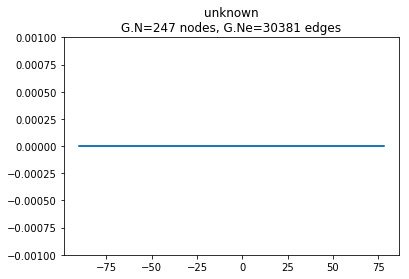

In [62]:

# Get the position of the nodes
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))
c_data.drop("United States Minor Outlying Islands",inplace = True)

weights_df = pd.DataFrame(weights,columns=countries,index=countries)
weights_df.drop("United States Minor Outlying Islands",inplace = True)
weights_df.drop("United States Minor Outlying Islands", axis = 1,inplace = True)


country_pos = np.array(c_data[['latlng']].as_matrix())
country_pos = [ np.array(x[0]) for x in country_pos]
country_pos = np.vstack(country_pos)


print(len(weights_df), len(country_pos))
# Create the graph
G = graphs.Graph(weights_df.as_matrix())

G.set_coordinates(country_pos[:,0])

# Create the heat diffusion filter
filt = filters.Heat(G, tau=0)

# Create the signal for a given country
country_ISO2 = "FR"
NODE = np.where(weights_df.index==country_ISO2)[0]
signal = np.zeros(G.N)
signal[NODE] = 1

# Apply the filter to the signal
filtered_s = filt.filter(signal)

# Plot the signal on the graph
G.plot_signal(filtered_s, vertex_size=50, highlight=NODE)
